## Optimized photonic crystal cavity

In this notebook, we will simulate an optimized version of the commonly used L3 photonic crystal cavity composed of three missing holes in a hexagonal lattice of holes in a silicon slab. The design we use was optimized in the paper [A full degree-of-freedom photonic crystal spatial light modulator](https://www.nature.com/articles/s41566-022-01086-9) to simultaneously have a very high quality factor and far-field emission strongly localized around the cavity normal direction.

In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d.plugins import ResonanceFinder
from tidy3d import web


[12:47:15] WARNING  This version of Tidy3D was pip installed from the         ]8;id=854577;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=299571;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#100\100]8;;\
                    'tidy3d-beta' repository on PyPI. Future releases will be                
                    uploaded to the 'tidy3d' repository. From now on, please                 
                    use 'pip install tidy3d' instead.                                        

           INFO     Using client version: 1.9.0                               ]8;id=76683;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=468976;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#115\115]8;;\

### Initialize geometry

We will read in hole positions and radii from file, in units of lattice constant. The holes are only defined in one quadrant so we have to use symmetry later on when defining the simulation. If symmetry is not applied in the simulation, we have to expand the hole list to append holes in the other quadrants. Note also that the holes correspond to a *periodic* arrangement of cavities, as for the spatial light modulator structure studied in the paper.

In [2]:
holes_file = np.loadtxt(join("misc", "optimized_L3_holes.txt"))
xs, ys, rs = holes_file.T  # in units of um


In [3]:
# Periodicity in units of PhC periods in x and y directions
nx, ny = 32, 32

# Lattice constant of the PhC in micron
alattice = 0.4

# Regular PhC lattice parameters
r_hole = 0.1  # radius of holes in regular PhC region
d_slab = 0.22  # slab thickness
n_slab = 3.4757  # refractive index of the slab

# Materials - air and silicon
air = td.Medium()
si = td.Medium(permittivity=n_slab**2)

# Simulation domain size (micron)
size_z = 6
sim_size = [(nx + 1) * alattice, (ny + 1) * alattice * np.sqrt(3) / 2, size_z]


In [4]:
# Initialize structures
slab = td.Structure(
    geometry=td.Box(center=[0, 0, 0], size=[td.inf, td.inf, d_slab]), medium=si
)

holes_group = []
# Add all provided optimized holes
for x, y, r in zip(xs, ys, rs):
    holes_group.append(td.Cylinder(center=[x, y, 0], radius=r, length=d_slab))

# Pad with regular PhC holes outside of the optimized region
xmax_opt = np.amax(np.int64(xs / alattice))
ymax_opt = np.amax(np.int64(ys / alattice * 2 / np.sqrt(3)))
nx_pos, ny_pos = nx // 2 + 1, ny // 2 + 1
for iy in range(ny_pos):
    for ix in range(nx_pos):
        if ix > xmax_opt or iy > ymax_opt:
            xp = ix + (iy % 2) * 0.5
            yp = iy * np.sqrt(3) / 2
            holes_group.append(
                td.Cylinder(center=[xp, yp, 0], radius=r_hole, length=d_slab)
            )

holes = td.Structure(geometry=td.GeometryGroup(geometries=holes_group), medium=air)


### Initialize source

We will be looking for the fundamental mode of the L3 cavity, so we use a y-polarized source at the center of the cavity.

<Axes: title={'center': 'source spectrum'}, xlabel='frequency (Hz)'>

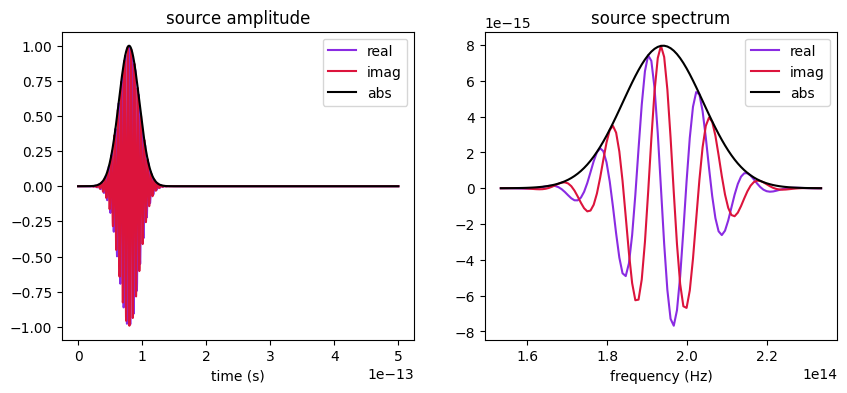

In [5]:
# Central frequency around which we'll look for the cavity mode (Hz)
wavelength = 1.55
freq0 = td.C_0 / wavelength

# Source bandwidth (Hz)
fwidth = 1e13

# Simulation run time (s)
run_time = 10e-12

# Source; plot time dependence to verify when the source pulse decayed
source = td.PointDipole(
    center=(0, 0, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    polarization="Ey",
)

# Source pulse is much shorter than the simulation run_time defined above,
# so we only examine the signal up to a shorter time = 5e-13fs
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
source.source_time.plot(np.linspace(0, 5e-13, 2000), ax=ax[0])
source.source_time.plot_spectrum(times=np.linspace(0, 5e-13, 2000), ax=ax[1]);


### Initialize monitors

We will use three different types of monitors. The first one is a time domain monitor at a single point at the center of the cavity, which we will use to determine the resonance frequency and quality factor of the mode. The second is a frequency-domain monitor recording the near field of the mode at the slab center. The third monitor is a far field projection monitor placed right above the slab, which will help us visualize the emission profile of the cavity mode.

For all of those monitors, it is important to exclude the contribution of the source pulse and study only the long-lived cavity mode. In the time monitor, this is achieved by setting the starting time to after the source has decayed. In the frequency-domain monitors, this is achieved using apodization, which applies a windowing function to the running Fourier transform.

In [6]:
# Starting time after the source has decayed for time series and
# for apodization of frequency domain monitors
t_start = 4e-13

# Time series monitor for Q-factor computation
time_series_mnt = td.FieldTimeMonitor(
    center=[0, 0, 0], size=[0, 0, 0], start=t_start, name="time_series"
)

# Apodization to exclude the source pulse from the frequency-domain monitors
apodization = td.ApodizationSpec(start=t_start, width=2e-13)

# near field
field_mnt = td.FieldMonitor(
    center=[0, 0, 0],
    size=[4, 2 * np.sqrt(3), 0],
    freqs=[freq0],
    name="field",
    apodization=apodization,
)

# far field
ux = np.linspace(-1, 1, 101)
uy = np.linspace(-1, 1, 101)
far_field_mnt = td.FieldProjectionKSpaceMonitor(
    center=(0, 0, d_slab / 2 + 0.1),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="n2f_monitor",
    proj_axis=2,
    ux=ux,
    uy=uy,
    apodization=apodization,
)


### Define and run simulation

In structures with (quasi)-periodicity, meaning with a well-defined notion of a unit cell, it is usually best to use a grid that is commensurate with the periodicity. This is why here we use a uniform grid in x and y, with a different step size to account for the different periodicity of the PhC lattice in these directions. In z, we use an automatic nonuniform mesh which conforms to the slab thickness and is finer in the silicon region.

We initialize the simulation with reflection symmetries defined with respect to the x-, y-, and z-planes. Note that the eigenvalue of the symmetry (plus or minus one) has to be carefully determined, taking into account the vectorial nature of the electric field (and the pseudo-vector nature of the magnetic field). As an extra hint, positive symmetry is equivalent to a PMC plane, where the normal E-field component vanishes, while negative symmetry is equivalent to a PEC plane, where the parallel components of the E-field vanish. The symmetry values can be determined by thinking about a y-polarized electric dipole at the origin: (1, -1, 1).

In [7]:
# Suppress warnings for some of the holes being too close to the PML
td.config.logging_level = "error"

# Mesh step in x, y, z, in micron
steps_per_unit_length = 20
grid_spec = td.GridSpec(
    grid_x=td.UniformGrid(dl=alattice / steps_per_unit_length),
    grid_y=td.UniformGrid(dl=alattice / steps_per_unit_length * np.sqrt(3) / 2),
    grid_z=td.AutoGrid(min_steps_per_wvl=steps_per_unit_length),
)

# Simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[slab, holes],
    sources=[source],
    monitors=[time_series_mnt, field_mnt, far_field_mnt],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    symmetry=(1, -1, 1),
    shutoff=0,
)


<Axes: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

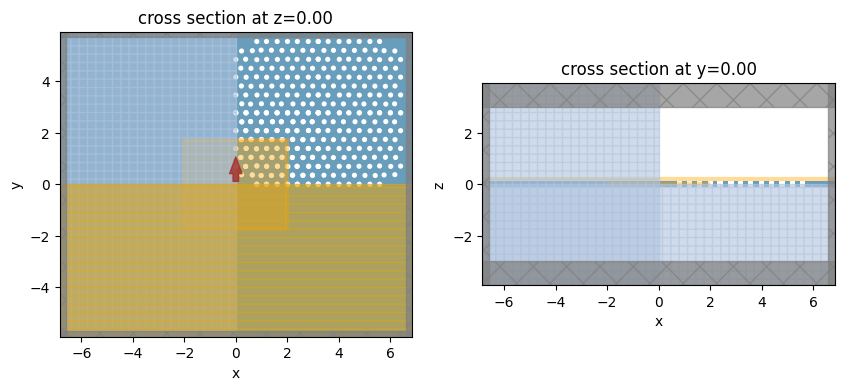

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim.plot(z=0, ax=ax[0])
sim.plot(y=0, ax=ax[1]);


In [9]:
sim_data = web.run(sim, task_name="L3_opt")


Output()

Output()

Output()

Output()

Output()

### Analyze data

First, we can examine the raw time series data and we can also compute the spectrum corresponding to it.

Text(0.5, 1.0, 'Spectrum')

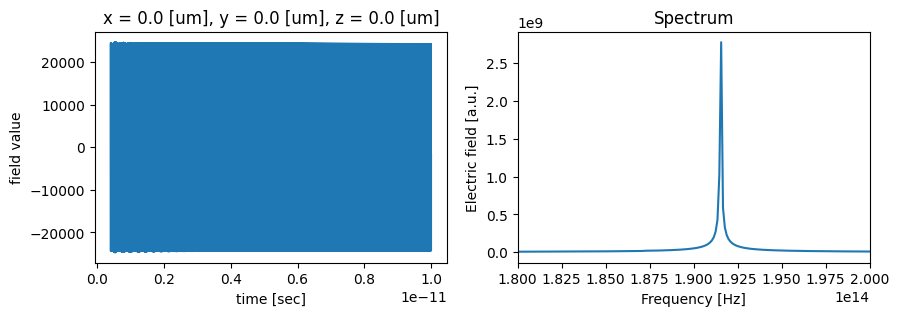

In [10]:
# Get data from the TimeMonitor
tdata = sim_data["time_series"]

time_series = tdata.Ey.squeeze()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot time dependence
time_series.plot(ax=ax1)

# Make frequency mesh and plot spectrum
dt = sim_data.simulation.dt
fmesh = np.linspace(-1 / dt / 2, 1 / dt / 2, time_series.size)
spectrum = np.fft.fftshift(np.fft.fft(time_series))

ax2.plot(fmesh, np.abs(spectrum))
ax2.set_xlim(1.8e14, 2e14)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Electric field [a.u.]")
ax2.set_title("Spectrum");


We can see that there is a sharp peak in the spectrum around 192THz, and a very slow decay of the field in the simulation, indicating a very high-Q mode. For such modes, it is virtually impossible to run the FDTD simulation until the fields have decayed. However, we can use the Tidy3D resonance finder plugin to estimate the exact resonance frequency and Q of the mode much better than what we can see from the plots above.

In [11]:
resonance_finder = ResonanceFinder(freq_window=(1.8e14, 2e14), init_num_freqs=100)
resonance_data = resonance_finder.run(sim_data["time_series"])
resonance_data.to_dataframe()


,decay,Q,amplitude,phase,error
freq,,,,,
1.915336e+14,6.955560e+08,865092.818573,12193.269248,-0.094253,0.002133


We can also have a look at the cavity mode as stored in the near field monitor.

<Axes: title={'center': 'z = 0.0 [um]'}, xlabel='x position [um]', ylabel='y position [um]'>

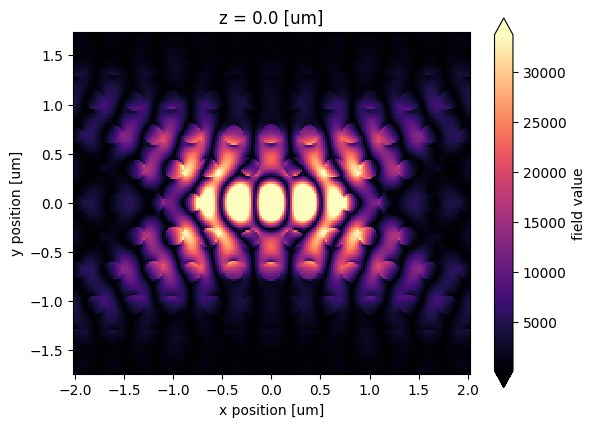

In [12]:
fig, ax = plt.subplots(1)
sim_data.plot_field("field", "Ey", val="abs", z=0, ax=ax, eps_alpha=0);


Finally, we can also plot the far field radiation pattern associated to this mode, which was optimized to be as concentrated as possible around the normal direction. In fact, it is almost entirely confined within the field-of-view associated to the cavity array, given by $\lambda / L$, where $L$ is the periodicity along a direction. This field of view in 2D is plotted with a white circle below.

Text(0, 0.5, 'normalized $k_y$')

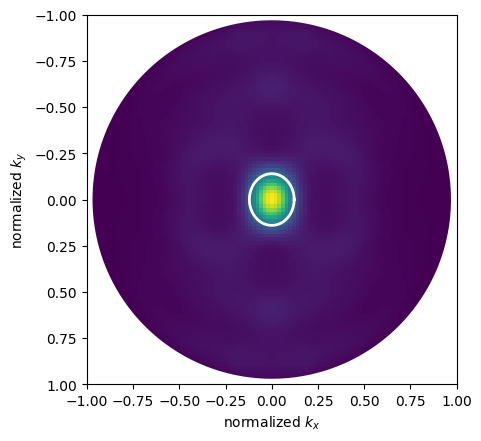

In [13]:
fig, ax = plt.subplots(1)
cavity_rcs = np.abs(sim_data["n2f_monitor"].power)
ax.imshow(np.squeeze(cavity_rcs).T, extent=[-1, 1, 1, -1])

phis = np.linspace(0, np.pi * 2, 201)
ax.plot(np.cos(phis), np.sin(phis), lw=8, color="w")
Lx, Ly = nx * alattice, ny * alattice * np.sqrt(3) / 2
ax.plot(wavelength / Lx * np.cos(phis), wavelength / Ly * np.sin(phis), lw=2, color="w")
ax.set_xlabel("normalized $k_x$")
ax.set_ylabel("normalized $k_y$");
